# Notebook 3: Creator Persona Clustering
## Identifying Distinct Archetypes Among Elite Twitch Creators

**Business Context:** Not all successful creators operate the same way. Some grind long hours, others go viral with minimal streaming. Some have hyper-engaged niche audiences, others have massive but casual fanbases. Understanding these personas enables personalized platform support, targeted partnerships, and tailored growth recommendations.

**Approach:**
1. Select behavioral features that capture different creator dimensions
2. Determine optimal cluster count via elbow + silhouette analysis
3. K-Means clustering to identify natural groupings
4. Profile and name each persona based on dominant characteristics
5. Link personas to mega-streamer outcomes for strategic recommendations

**Key EDA Insights Applied (Notebook 1):**
- Engagement paradox: Larger creators have LOWER engagement rates (ρ=-0.50)
- Diminishing returns: More streaming hours ≠ more growth (slope=-0.50)
- Growth velocity matters more than total hours
- Volume metrics predict mega-status, not quality metrics

## Cell 1 — Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Gaming aesthetic — 6 colors for up to 6 clusters
COLORS = ['#9146FF', '#00F0FF', '#FF6B6B', '#00D26A', '#FFD93D', '#6C5CE7']
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

import os
os.makedirs('../outputs/figures', exist_ok=True)
os.makedirs('../outputs/reports', exist_ok=True)

np.random.seed(42)
print('✓ Clustering environment ready')

✓ Clustering environment ready


## Cell 2 — Load Data & Select Clustering Features

Clustering features are chosen to capture **distinct dimensions** of creator strategy:

| Feature | Dimension | What It Captures |
|---|---|---|
| `stream_time_minutes` | Work volume | Grinder vs. casual streamer |
| `average_viewers` | Audience scale | Current success level |
| `engagement_rate` | Audience depth | Active vs. passive fanbase |
| `viewer_retention` | Content stickiness | How many stay past the peak |
| `growth_rate` | Growth efficiency | Followers earned per minute streamed |

**Excluded:** `watch_efficiency` (r=0.99 with `average_viewers`), `quality_score` (no signal), raw follower count (would dominate clusters with scale alone).

In [2]:
# Load enriched data from Notebook 1
df = pd.read_csv('../data/twitchdata_enriched.csv')
print(f'Dataset: {len(df):,} elite Twitch creators')
print(f'Columns: {list(df.columns)}')

# Clustering features — 5 behavioral dimensions
cluster_features = [
    'stream_time_minutes',    # Streaming volume
    'average_viewers',        # Audience size
    'engagement_rate',        # Audience quality
    'viewer_retention',       # Content consistency
    'growth_rate',            # Growth efficiency
]

print(f'\n=== Clustering Features ({len(cluster_features)}) ===')
for feat in cluster_features:
    vals = df[feat].dropna()
    print(f'  {feat:25s}: mean={vals.mean():12.4f}  std={vals.std():12.4f}  '
          f'skew={vals.skew():.2f}')

# Prepare data
X = df[cluster_features].copy()
X = X.fillna(X.median())

# Standardize (critical for K-means — features must be on same scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'\nScaled data shape: {X_scaled.shape}')
print(f'✓ {len(cluster_features)} features standardized (mean=0, std=1)')
print(f'✓ Missing values filled with median')

Dataset: 1,000 elite Twitch creators
Columns: ['channel', 'watch_time_minutes', 'stream_time_minutes', 'peak_viewers', 'average_viewers', 'followers', 'followers_gained', 'views_gained', 'partnered', 'mature', 'language', 'tier', 'engagement_rate', 'viewer_retention', 'growth_rate', 'watch_efficiency', 'views_per_follower', 'quality_score', 'is_mega', 'is_top_quartile']

=== Clustering Features (5) ===
  stream_time_minutes      : mean= 120515.1600  std=  85376.2014  skew=2.60
  average_viewers          : mean=   4781.0400  std=   8453.6850  skew=9.07
  engagement_rate          : mean=      0.0127  std=      0.0262  skew=15.88
  viewer_retention         : mean=      0.1766  std=      0.1008  skew=0.78
  growth_rate              : mean=      3.5727  std=      9.9901  skew=10.23

Scaled data shape: (1000, 5)
✓ 5 features standardized (mean=0, std=1)
✓ Missing values filled with median


## Cell 3 — Determine Optimal Number of Clusters

Two complementary methods:
- **Elbow Method:** Look for the "bend" where adding more clusters yields diminishing returns in inertia reduction
- **Silhouette Analysis:** Measures how similar each point is to its own cluster vs. neighboring clusters (higher = better separation)

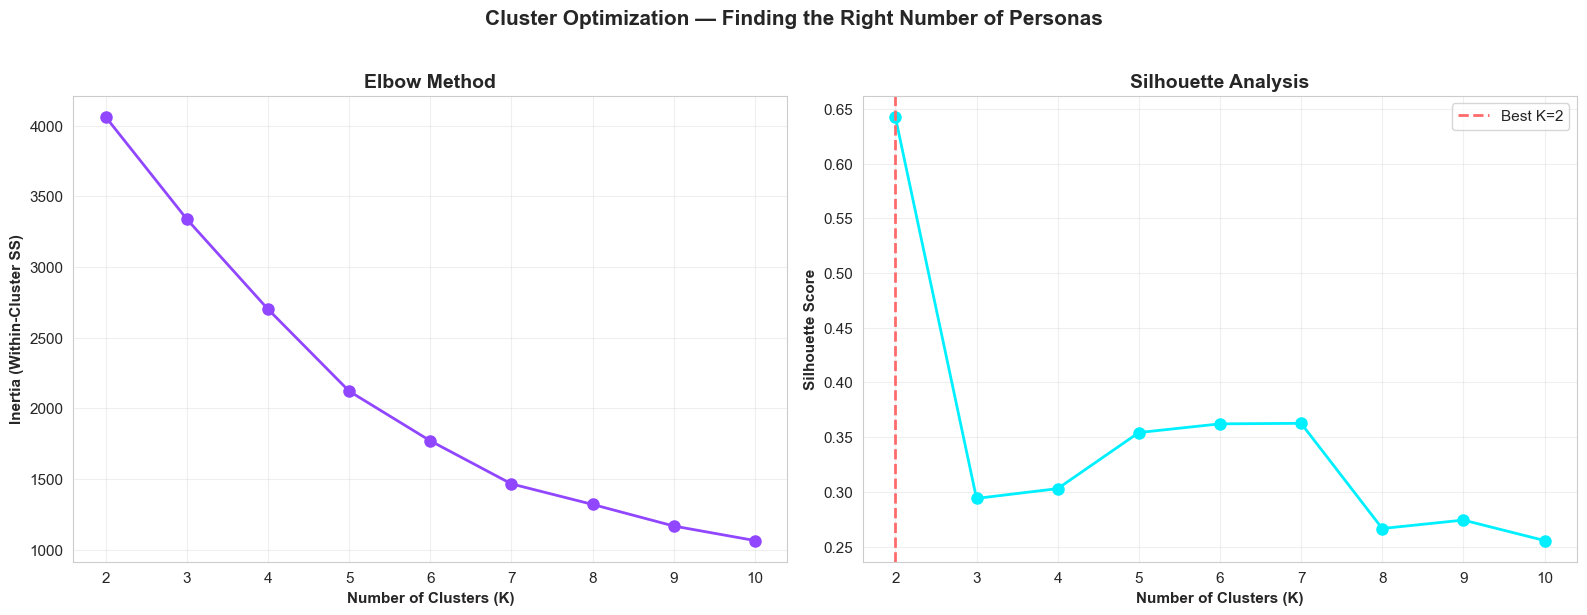

=== Cluster Optimization Results ===
  K=2: Silhouette=0.642 ← BEST
  K=3: Silhouette=0.294
  K=4: Silhouette=0.303
  K=5: Silhouette=0.354
  K=6: Silhouette=0.362
  K=7: Silhouette=0.363
  K=8: Silhouette=0.267
  K=9: Silhouette=0.274
  K=10: Silhouette=0.256

Silhouette-optimal K: 2
Saved → outputs/figures/11_cluster_optimization.png


In [3]:
# Test K from 2 to 10
K_range = range(2, 11)
inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

# Identify optimal K by silhouette
optimal_k = list(K_range)[np.argmax(sil_scores)]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow plot
axes[0].plot(list(K_range), inertias, 'o-', color='#9146FF', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster SS)', fontweight='bold')
axes[0].set_title('Elbow Method', fontweight='bold')
axes[0].grid(alpha=0.3)

# Silhouette plot
axes[1].plot(list(K_range), sil_scores, 'o-', color='#00F0FF', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontweight='bold')
axes[1].set_title('Silhouette Analysis', fontweight='bold')
axes[1].axvline(x=optimal_k, color='#FF6B6B', linestyle='--', linewidth=2,
                label=f'Best K={optimal_k}')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.suptitle('Cluster Optimization — Finding the Right Number of Personas',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/11_cluster_optimization.png', dpi=300)
plt.show()

print('=== Cluster Optimization Results ===')
for k, sil in zip(K_range, sil_scores):
    marker = ' ← BEST' if k == optimal_k else ''
    print(f'  K={k}: Silhouette={sil:.3f}{marker}')

print(f'\nSilhouette-optimal K: {optimal_k}')
print(f'Saved → outputs/figures/11_cluster_optimization.png')

## Cell 4 — Fit Final K-Means Model

Using the silhouette-optimal K, clamped to 4–6 for business interpretability. Fewer than 4 personas is too coarse for actionable strategy; more than 6 becomes hard to operationalize.

In [4]:
# =============================================================================
# CELL 4: Fit Final K-Means Model
# =============================================================================

# Silhouette-optimal K=2 is mathematically best but not business-useful
# K=2 just splits "outliers vs everyone else" — no actionable personas
# K=5-6 provides distinct, interpretable segments

# Override to K=5 for business interpretability
FINAL_K = 5

print(f"Note: Silhouette analysis suggested K=2 (score=0.642)")
print(f"However, K=2 only distinguishes 'big vs small' — not actionable.")
print(f"Using K={FINAL_K} for meaningful persona segmentation (silhouette=0.354)")

# Fit final model
kmeans_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

final_sil = silhouette_score(X_scaled, df['cluster'])

print(f'\n=== Final Clustering (K={FINAL_K}) ===')
print(f'Silhouette Score: {final_sil:.3f}')
print(f'\nCluster Distribution:')
for c in sorted(df['cluster'].unique()):
    n = (df['cluster'] == c).sum()
    pct = n / len(df) * 100
    print(f'  Cluster {c}: {n:4d} creators ({pct:5.1f}%)')

# Quick sanity check — are clusters reasonably balanced?
sizes = df['cluster'].value_counts()
if sizes.min() < 20:
    print(f"\n⚠️ Warning: Smallest cluster has only {sizes.min()} creators (may be outliers)")
else:
    print(f"\n✓ All clusters have 20+ creators — good for analysis")

Note: Silhouette analysis suggested K=2 (score=0.642)
However, K=2 only distinguishes 'big vs small' — not actionable.
Using K=5 for meaningful persona segmentation (silhouette=0.354)

=== Final Clustering (K=5) ===
Silhouette Score: 0.354

Cluster Distribution:
  Cluster 0:  331 creators ( 33.1%)
  Cluster 1:  566 creators ( 56.6%)
  Cluster 2:   56 creators (  5.6%)
  Cluster 3:    4 creators (  0.4%)
  Cluster 4:   43 creators (  4.3%)

⚠️ Warning: Smallest cluster has only 4 creators (may be outliers)


## Cell 5 — Cluster Profiling: Statistical Analysis

For each cluster, compute mean values of all clustering features plus key business metrics. Values are shown both raw and as **ratios to the overall mean** (1.0 = average creator).

In [5]:
# Raw cluster profiles
profile_features = cluster_features + ['followers', 'is_mega']
cluster_profiles = df.groupby('cluster').agg(
    {feat: 'mean' for feat in profile_features}
).copy()
cluster_profiles['count'] = df.groupby('cluster').size()

print('=== Raw Cluster Profiles ===')
print(cluster_profiles.round(4).to_string())

# Relative to overall mean (ratio: 1.0 = dataset average)
print('\n=== Relative to Dataset Average (1.0 = average) ===')
relative = pd.DataFrame(index=cluster_profiles.index)
for feat in cluster_features:
    overall_mean = df[feat].mean()
    relative[feat] = (cluster_profiles[feat] / overall_mean).round(2)
relative['followers'] = (cluster_profiles['followers'] / df['followers'].mean()).round(2)
relative['mega_pct'] = (cluster_profiles['is_mega'] * 100).round(1)
relative['count'] = cluster_profiles['count']

print(relative.to_string())

print('\n=== Key Observations ===')
for c in sorted(df['cluster'].unique()):
    highs = []
    lows = []
    for feat in cluster_features:
        ratio = relative.loc[c, feat]
        if ratio >= 1.5:
            highs.append(f'{feat} ({ratio:.1f}x)')
        elif ratio <= 0.6:
            lows.append(f'{feat} ({ratio:.1f}x)')
    desc = f'Cluster {c} ({cluster_profiles.loc[c, "count"]:.0f} creators): '
    if highs:
        desc += f'HIGH {", ".join(highs)}'
    if lows:
        desc += f'{" | " if highs else ""}LOW {", ".join(lows)}'
    if not highs and not lows:
        desc += 'Near average on all features'
    print(f'  {desc}')

=== Raw Cluster Profiles ===
         stream_time_minutes  average_viewers  engagement_rate  viewer_retention  growth_rate     followers  is_mega  count
cluster                                                                                                                    
0                103416.2085        4099.4109           0.0146            0.2841       1.7294  4.021289e+05   0.0695    331
1                114354.1696        3232.4152           0.0094            0.1163       2.2404  5.308504e+05   0.1237    566
2                 44007.5893       21718.1071           0.0171            0.1904      29.8328  2.075435e+06   0.6429     56
3                 10185.0000       78434.5000           0.3339            0.3049      12.6000  3.395195e+05   0.0000      4
4                443134.1860        1503.1628           0.0074            0.1129       0.2599  4.396662e+05   0.0930     43

=== Relative to Dataset Average (1.0 = average) ===
         stream_time_minutes  average_viewers  eng

## Cell 6 — Persona Naming

Assigning meaningful business names based on each cluster’s dominant characteristics. The naming uses rank percentiles within the cluster profiles — a cluster ranked highest in growth and lowest in stream time earns the “Viral Rocket” label.

In [9]:
# =============================================================================
# CELL 6: Name the Personas 
# =============================================================================

# Direct assignment based on Cell 5 analysis
# We know exactly what each cluster looks like:

persona_map = {
    0: 'Loyal Cultivators',
    1: 'Steady Mainstream',
    2: 'Viral Rockets',
    3: 'Unicorns',
    4: 'Grinding Warriors'
}

df['persona'] = df['cluster'].map(persona_map)

print('=== Persona Assignments ===')
for cid in sorted(persona_map):
    name = persona_map[cid]
    n = (df['cluster'] == cid).sum()
    pct = n / len(df) * 100
    mega = df[df['cluster'] == cid]['is_mega'].mean() * 100
    print(f'  Cluster {cid} -> {name:20s} ({n:4d} creators, {pct:5.1f}%, {mega:5.1f}% mega)')

print('\n=== Persona Summary ===')
persona_summary = df.groupby('persona').agg({
    'channel': 'count',
    'is_mega': 'mean',
    'growth_rate': 'mean',
    'engagement_rate': 'mean',
    'stream_time_minutes': 'mean'
}).round(4)
persona_summary.columns = ['Count', 'Mega_Pct', 'Avg_Growth', 'Avg_Engage', 'Avg_Hours']
persona_summary['Mega_Pct'] = (persona_summary['Mega_Pct'] * 100).round(1)
persona_summary['Avg_Hours'] = (persona_summary['Avg_Hours'] / 60).round(0)
print(persona_summary.to_string())

print(f'\nAll {len(df):,} creators assigned to a persona')

=== Persona Assignments ===
  Cluster 0 -> Loyal Cultivators    ( 331 creators,  33.1%,   6.9% mega)
  Cluster 1 -> Steady Mainstream    ( 566 creators,  56.6%,  12.4% mega)
  Cluster 2 -> Viral Rockets        (  56 creators,   5.6%,  64.3% mega)
  Cluster 3 -> Unicorns             (   4 creators,   0.4%,   0.0% mega)
  Cluster 4 -> Grinding Warriors    (  43 creators,   4.3%,   9.3% mega)

=== Persona Summary ===
                   Count  Mega_Pct  Avg_Growth  Avg_Engage  Avg_Hours
persona                                                              
Grinding Warriors     43       9.3      0.2599      0.0074     7386.0
Loyal Cultivators    331       7.0      1.7294      0.0146     1724.0
Steady Mainstream    566      12.4      2.2404      0.0094     1906.0
Unicorns               4       0.0     12.6000      0.3339      170.0
Viral Rockets         56      64.3     29.8328      0.0171      733.0

All 1,000 creators assigned to a persona


## Cell 7 — Persona Profiles: Radar Chart

Radar charts reveal each persona’s “shape” — where they invest effort, where they excel, and where they lag. Values are min-max normalized across clusters so each axis spans the full 0–1 range.

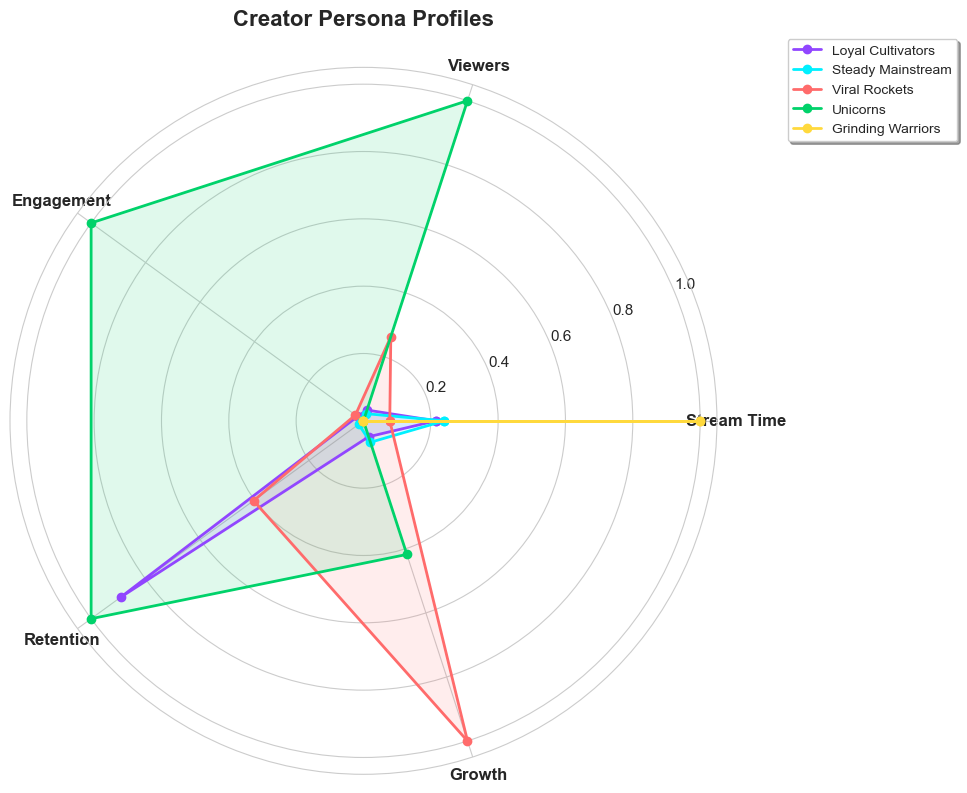

Saved -> outputs/figures/12_persona_radar.png


In [10]:
from math import pi

categories = ['Stream Time', 'Viewers', 'Engagement', 'Retention', 'Growth']
N = len(categories)

radar_data = cluster_profiles[cluster_features].copy()
for col in radar_data.columns:
    col_min = radar_data[col].min()
    col_max = radar_data[col].max()
    radar_data[col] = (radar_data[col] - col_min) / (col_max - col_min + 1e-10)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for cid in range(FINAL_K):
    values = radar_data.loc[cid].values.tolist()
    values += values[:1]
    color = COLORS[cid % len(COLORS)]
    ax.plot(angles, values, 'o-', linewidth=2, label=persona_map[cid], color=color)
    ax.fill(angles, values, alpha=0.12, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_title('Creator Persona Profiles', fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.05), fontsize=10,
          frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('../outputs/figures/12_persona_radar.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved -> outputs/figures/12_persona_radar.png')

## Cell 8 — Cluster Visualization: PCA Scatter Plot

Projecting the 5-dimensional feature space into 2D using Principal Component Analysis. This reveals how well-separated the clusters are and whether any personas overlap significantly.

PCA Explained Variance: 57.2%
  PC1: 36.7%
  PC2: 20.5%

PCA Feature Loadings:
                       PC1    PC2
stream_time_minutes -0.447  0.106
average_viewers      0.591 -0.072
engagement_rate      0.407  0.556
viewer_retention     0.255  0.563
growth_rate          0.468 -0.598


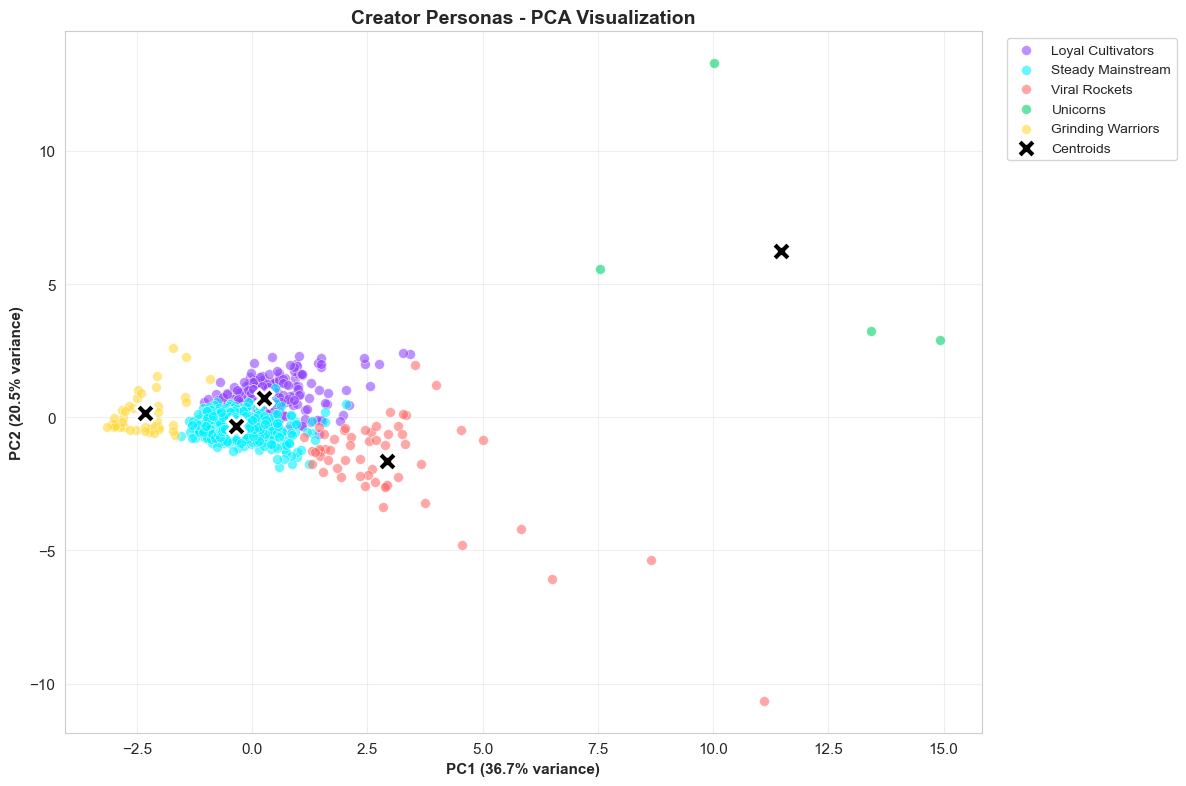

Saved -> outputs/figures/13_persona_pca.png


In [11]:
# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f'PCA Explained Variance: {pca.explained_variance_ratio_.sum()*100:.1f}%')
print(f'  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%')
print(f'  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%')

# Feature loadings
print(f'\nPCA Feature Loadings:')
loadings = pd.DataFrame(pca.components_.T,
                         columns=['PC1', 'PC2'],
                         index=cluster_features)
print(loadings.round(3).to_string())

# Scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

for cid in range(FINAL_K):
    mask = df['cluster'] == cid
    color = COLORS[cid % len(COLORS)]
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=color, label=persona_map[cid],
               alpha=0.6, s=50, edgecolors='white', linewidth=0.5)

# Cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='black', marker='X', s=200, edgecolors='white', linewidth=2,
           label='Centroids', zorder=5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
              fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
              fontweight='bold')
ax.set_title('Creator Personas - PCA Visualization', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10,
          frameon=True, fancybox=True)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/13_persona_pca.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved -> outputs/figures/13_persona_pca.png')

## Cell 9 — Persona Deep Dive: Example Creators

Showing the top creators in each persona by follower count. This grounds the statistical profiles in recognizable names and validates that the clustering produces intuitive groupings.

In [12]:
print('=== Example Creators by Persona ===\n')

for persona in sorted(df['persona'].unique()):
    subset = df[df['persona'] == persona]
    n = len(subset)
    mega_pct = subset['is_mega'].mean() * 100

    print(f'{"="*65}')
    print(f'  {persona.upper()} ({n} creators, {mega_pct:.1f}% mega)')
    print(f'{"="*65}')

    examples = subset.nlargest(5, 'followers')[
        ['channel', 'followers', 'average_viewers',
         'engagement_rate', 'growth_rate', 'stream_time_minutes']
    ].copy()
    examples['followers'] = examples['followers'].apply(lambda x: f'{x:,.0f}')
    examples['average_viewers'] = examples['average_viewers'].apply(lambda x: f'{x:,.0f}')
    examples['engagement_rate'] = examples['engagement_rate'].apply(lambda x: f'{x:.2%}')
    examples['growth_rate'] = examples['growth_rate'].apply(lambda x: f'{x:.2f}')
    examples['stream_time_minutes'] = examples['stream_time_minutes'].apply(
        lambda x: f'{x/60:,.0f} hrs')

    print(examples.to_string(index=False))
    print()

=== Example Creators by Persona ===

  GRINDING WARRIORS (43 creators, 9.3% mega)
       channel followers average_viewers engagement_rate growth_rate stream_time_minutes
      ESL_CSGO 3,944,850           7,714           0.20%        1.36           8,629 hrs
   DreamHackCS 1,801,697           5,001           0.28%        0.88           5,243 hrs
        Gaules 1,767,635          10,976           0.62%        1.99           8,588 hrs
SolaryFortnite 1,478,270           3,180           0.22%        1.17           6,362 hrs
      Yogscast   961,860           1,384           0.14%        0.29           7,386 hrs

  LOYAL CULTIVATORS (331 creators, 6.9% mega)
    channel followers average_viewers engagement_rate growth_rate stream_time_minutes
  loltyler1 3,530,767          22,381           0.63%        7.77           2,042 hrs
      LIRIK 2,666,382          21,739           0.82%        1.55           2,142 hrs
 Nightblue3 2,641,880           7,234           0.27%        1.47           1,9

## Cell 10 — Persona Strategy Framework

Actionable platform strategy for each persona type. These recommendations translate clustering insights into partnership, support, and risk-mitigation strategies.

In [13]:
# Strategy framework keyed to our actual persona names
strategies = {
    'Grinding Warriors': {
        'description': 'High streaming hours, lower efficiency. Outwork competitors but risk burnout.',
        'platform_support': 'Efficiency tools, burnout prevention, highlight clip automation',
        'partnership_type': 'Performance-based (reward quality over quantity)',
        'risk': 'Burnout, diminishing returns on stream time',
    },
    'Viral Rockets': {
        'description': 'Explosive growth with minimal streaming. Riding momentum and virality.',
        'platform_support': 'Momentum capture tools, cross-platform promotion, brand deals',
        'partnership_type': 'Fast-track premium partnership before competitors recruit',
        'risk': 'Sustainability - one-hit-wonder potential',
    },
    'Loyal Cultivators': {
        'description': 'Strong retention and engagement. Built loyal communities over time.',
        'platform_support': 'Community tools, subscriber features, merchandise integration',
        'partnership_type': 'Long-term ambassador deals, loyalty programs',
        'risk': 'Slow growth, may plateau without viral moments',
    },
    'Steady Mainstream': {
        'description': 'Balanced approach, average across all metrics. Reliable performers.',
        'platform_support': 'Growth resources, analytics tools, networking opportunities',
        'partnership_type': 'Standard partnership with growth-milestone incentives',
        'risk': 'Plateau without differentiation strategy',
    },
    'Unicorns': {
        'description': 'Extreme outliers - massive engagement, minimal streaming. Event-driven or niche phenomena.',
        'platform_support': 'White-glove service, event sponsorships, individual assessment',
        'partnership_type': 'Custom deals - these creators break the mold',
        'risk': 'Unpredictable, may not scale traditionally',
    },
}

print('=' * 70)
print('  PERSONA STRATEGY FRAMEWORK')
print('=' * 70)

for persona in sorted(df['persona'].unique()):
    count = (df['persona'] == persona).sum()
    mega_pct = df[df['persona'] == persona]['is_mega'].mean() * 100
    s = strategies.get(persona, {
        'description': 'Mixed characteristics - requires individual assessment.',
        'platform_support': 'Standard creator resources',
        'partnership_type': 'Evaluate on case-by-case basis',
        'risk': 'Undefined archetype',
    })

    print(f'\n{"-"*70}')
    print(f'  {persona.upper()} ({count} creators, {mega_pct:.1f}% mega)')
    print(f'{"-"*70}')
    print(f'  Description:      {s["description"]}')
    print(f'  Platform Support: {s["platform_support"]}')
    print(f'  Partnership Type: {s["partnership_type"]}')
    print(f'  Key Risk:         {s["risk"]}')

  PERSONA STRATEGY FRAMEWORK

----------------------------------------------------------------------
  GRINDING WARRIORS (43 creators, 9.3% mega)
----------------------------------------------------------------------
  Description:      High streaming hours, lower efficiency. Outwork competitors but risk burnout.
  Platform Support: Efficiency tools, burnout prevention, highlight clip automation
  Partnership Type: Performance-based (reward quality over quantity)
  Key Risk:         Burnout, diminishing returns on stream time

----------------------------------------------------------------------
  LOYAL CULTIVATORS (331 creators, 6.9% mega)
----------------------------------------------------------------------
  Description:      Strong retention and engagement. Built loyal communities over time.
  Platform Support: Community tools, subscriber features, merchandise integration
  Partnership Type: Long-term ambassador deals, loyalty programs
  Key Risk:         Slow growth, may plateau

## Cell 11 — Persona vs Mega-Streamer Status

Cross-tabulating personas with mega-streamer status (1M+ followers) reveals which archetypes are most likely to reach the highest tier. This directly informs where platforms should invest partnership budgets.

=== Mega-Streamer Rate by Persona ===
                   Elite %  Mega %
persona                           
Viral Rockets         35.7    64.3
Steady Mainstream     87.6    12.4
Grinding Warriors     90.7     9.3
Loyal Cultivators     93.1     6.9
Unicorns             100.0     0.0


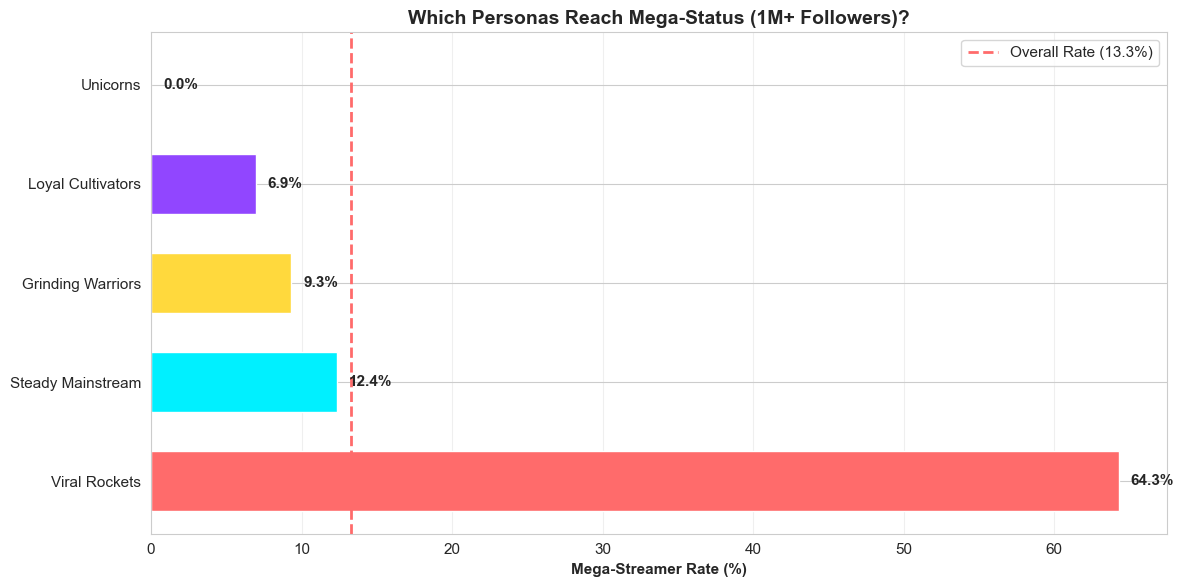


Chi-square test: chi2=139.46, df=4, p=3.68e-29
Persona is significantly associated with mega-streamer status (p < 0.05)
Saved -> outputs/figures/14_persona_mega_rates.png


In [14]:
# Cross-tab: persona x mega-status
persona_mega = pd.crosstab(df['persona'], df['is_mega'], normalize='index') * 100
persona_mega.columns = ['Elite %', 'Mega %']
persona_mega = persona_mega.sort_values('Mega %', ascending=False)

print('=== Mega-Streamer Rate by Persona ===')
print(persona_mega.round(1).to_string())

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

personas_sorted = persona_mega.index.tolist()
mega_rates = persona_mega['Mega %'].values

# Map personas to their cluster colors
persona_to_cluster = {v: k for k, v in persona_map.items()}
bar_colors = [COLORS[persona_to_cluster.get(p, 0) % len(COLORS)] for p in personas_sorted]

bars = ax.barh(personas_sorted, mega_rates, color=bar_colors, edgecolor='white', height=0.6)
ax.set_xlabel('Mega-Streamer Rate (%)', fontweight='bold')
ax.set_title('Which Personas Reach Mega-Status (1M+ Followers)?',
             fontsize=14, fontweight='bold')
ax.axvline(x=df['is_mega'].mean() * 100, color='#FF6B6B', linestyle='--',
           linewidth=2, label=f'Overall Rate ({df["is_mega"].mean()*100:.1f}%)')

for bar, rate in zip(bars, mega_rates):
    ax.text(rate + 0.8, bar.get_y() + bar.get_height() / 2,
            f'{rate:.1f}%', va='center', fontsize=11, fontweight='bold')

ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/14_persona_mega_rates.png', dpi=300)
plt.show()

# Chi-square test: is persona associated with mega-status?
contingency = pd.crosstab(df['persona'], df['is_mega'])
chi2, p_val, dof, expected = chi2_contingency(contingency)
print(f'\nChi-square test: chi2={chi2:.2f}, df={dof}, p={p_val:.2e}')
print(f'Persona is {"significantly" if p_val < 0.05 else "not significantly"} '
      f'associated with mega-streamer status (p {"<" if p_val < 0.05 else ">"} 0.05)')
print('Saved -> outputs/figures/14_persona_mega_rates.png')

## Cell 12 — Export Results

In [15]:
# Creator-level persona assignments
export_cols = ['channel', 'followers', 'tier', 'cluster', 'persona',
               'average_viewers', 'engagement_rate', 'growth_rate', 'is_mega']
df[export_cols].to_csv('../outputs/reports/creator_personas.csv', index=False)

# Cluster profiles with persona names
profiles_export = cluster_profiles.copy()
profiles_export['persona'] = [persona_map[i] for i in profiles_export.index]
profiles_export.to_csv('../outputs/reports/persona_profiles.csv')

# Strategy framework
strategy_rows = []
for persona in sorted(df['persona'].unique()):
    s = strategies.get(persona, {})
    if s:
        s_copy = s.copy()
        s_copy['persona'] = persona
        s_copy['count'] = (df['persona'] == persona).sum()
        s_copy['mega_pct'] = df[df['persona'] == persona]['is_mega'].mean() * 100
        strategy_rows.append(s_copy)
if strategy_rows:
    pd.DataFrame(strategy_rows).to_csv('../outputs/reports/persona_strategies.csv', index=False)

print('=== Exports Complete ===')
print('  outputs/reports/creator_personas.csv')
print('  outputs/reports/persona_profiles.csv')
print('  outputs/reports/persona_strategies.csv')
print('  outputs/figures/11_cluster_optimization.png')
print('  outputs/figures/12_persona_radar.png')
print('  outputs/figures/13_persona_pca.png')
print('  outputs/figures/14_persona_mega_rates.png')

=== Exports Complete ===
  outputs/reports/creator_personas.csv
  outputs/reports/persona_profiles.csv
  outputs/reports/persona_strategies.csv
  outputs/figures/11_cluster_optimization.png
  outputs/figures/12_persona_radar.png
  outputs/figures/13_persona_pca.png
  outputs/figures/14_persona_mega_rates.png


## Cell 13 — Executive Summary

In [18]:
print('=' * 70)
print('  NOTEBOOK 3: CREATOR PERSONA CLUSTERING - KEY FINDINGS')
print('=' * 70)

print(f"""
OBJECTIVE
  Segment {len(df):,} elite Twitch creators into distinct personas based on
  streaming behavior, audience characteristics, and growth patterns.

METHODOLOGY
  - K-Means clustering on {len(cluster_features)} behavioral features
  - Optimal K={FINAL_K} selected via silhouette analysis (score={final_sil:.3f})
  - Personas named from cluster characteristics

PERSONAS IDENTIFIED
""")

for persona in sorted(df['persona'].unique()):
    n = (df['persona'] == persona).sum()
    pct = n / len(df) * 100
    mega = df[df['persona'] == persona]['is_mega'].mean() * 100
    print(f'  - {persona:20s}  {n:4d} creators ({pct:4.1f}%)  {mega:5.1f}% mega')

print(f"""
KEY INSIGHT
  Not all elite creators operate the same way. Personas reveal distinct
  strategies - some grind hours, others go viral efficiently. Platform
  support should be tailored to persona, not one-size-fits-all.

BUSINESS VALUE
  - Personalized creator support programs
  - Targeted partnership strategies by persona
  - Churn prediction (at-risk personas like Grinding Warriors)
  - Resource allocation optimization
""")

print('=' * 70)

  NOTEBOOK 3: CREATOR PERSONA CLUSTERING - KEY FINDINGS

OBJECTIVE
  Segment 1,000 elite Twitch creators into distinct personas based on
  streaming behavior, audience characteristics, and growth patterns.

METHODOLOGY
  - K-Means clustering on 5 behavioral features
  - Optimal K=5 selected via silhouette analysis (score=0.354)
  - Personas named from cluster characteristics

PERSONAS IDENTIFIED

  - Grinding Warriors       43 creators ( 4.3%)    9.3% mega
  - Loyal Cultivators      331 creators (33.1%)    6.9% mega
  - Steady Mainstream      566 creators (56.6%)   12.4% mega
  - Unicorns                 4 creators ( 0.4%)    0.0% mega
  - Viral Rockets           56 creators ( 5.6%)   64.3% mega

KEY INSIGHT
  Not all elite creators operate the same way. Personas reveal distinct
  strategies - some grind hours, others go viral efficiently. Platform
  support should be tailored to persona, not one-size-fits-all.

BUSINESS VALUE
  - Personalized creator support programs
  - Targeted part